In [36]:
%load_ext autoreload
%autoreload 2

import sys
from functools import partial

import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp




sys.path.append('../../../')
from forward_model.ics import get_delta
from forward_model.fourier import get_k, my_fft, my_ifft
from forward_model.lpt import get_forward_lpt
from forward_model.plot_utils import plot_cubes, compare_pow_spec

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
N, L, Z_I, Z_F = 256, 100, 99, 0

SEED_INT = 1
key = jax.random.PRNGKey(SEED_INT)
input_arr = jax.random.normal(key, shape=(N,) * 3)

INPUT_ARG = "FSK_U"
LPT_METHOD = "ALPT"
R_S = 10
MUSCLE = True
MUSCLE_ITERS = "ONE"
SC_CORRECTION = True

get_forward_lpt_ = partial(
    get_forward_lpt,
    N,
    L,
    Z_I,
    Z_F,
    IC_KIND=INPUT_ARG,
    MUSCLE=MUSCLE,
    MUSCLE_ITERS=MUSCLE_ITERS,
    R_S=R_S,
    SC_CORRECTION=SC_CORRECTION,
)

forward_lpt = get_forward_lpt_(
    LPT_METHOD=LPT_METHOD,
)
delta_alpt = forward_lpt(input_arr)


forward_lpt = get_forward_lpt_(
    LPT_METHOD=LPT_METHOD,
    PARTICLE_RIDGE=True,
    K_TH_PR=1,
    D_PR=1,
)
delta_alpt_pr = forward_lpt(input_arr)

/home/pererossello/Documents/tfm/envs/cosmo-env-gpu-py39/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=device)
/home/pererossello/Documents/tfm/envs/cosmo-env-gpu-py39/lib/python3.9/site-packages/jax/_src/numpy/array_methods.py:68: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype, copy=copy, device=

ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 67108864 bytes.

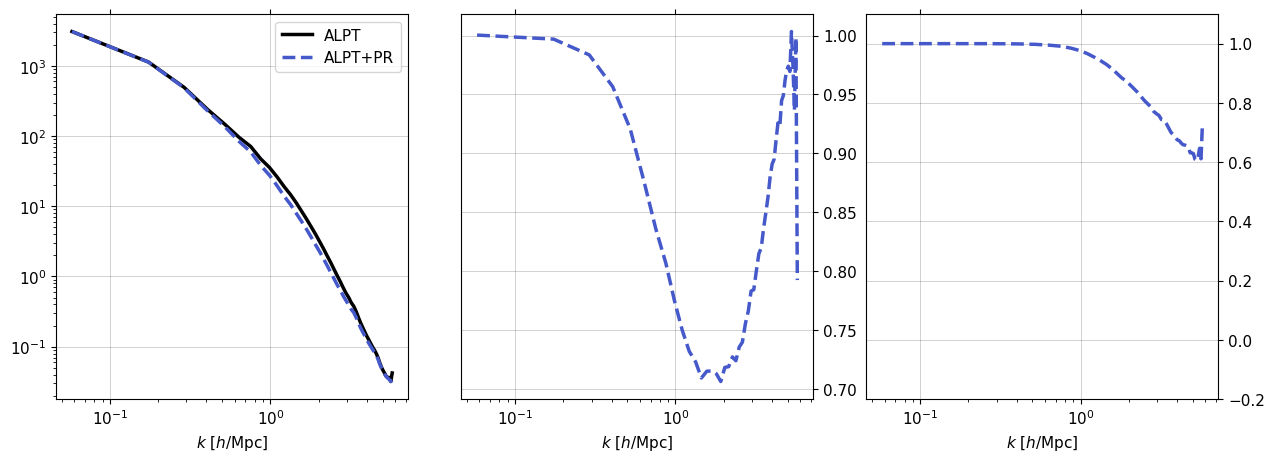

In [34]:
fig, axs = compare_pow_spec(
    [delta_alpt, delta_alpt_pr], L, n_bins=50, labels=["ALPT", "ALPT+PR"], xlog=True
)

# axs[1].set_xlim(0.1, 0.5)

(<Figure size 707.107x353.553 with 2 Axes>,
 array([<Axes: >, <Axes: >], dtype=object))

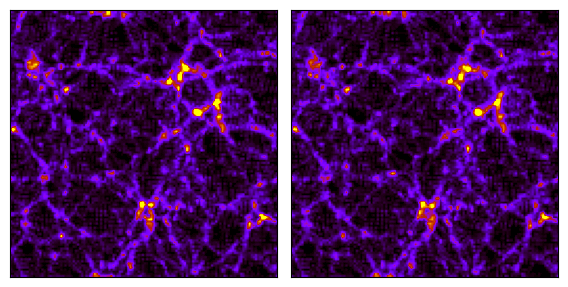

In [35]:
plot_cubes([delta_alpt, delta_alpt_pr], cmap='gnuplot', vlim=(-1, 10), idx=N//2, axis=2, width=1)

In [ ]:
N, L, Z_I, Z_F = 128, 120, 99, 0

SEED_INT = 1
key = jax.random.PRNGKey(SEED_INT)
input_arr = jax.random.normal(key, shape=(N**3,))

INPUT_ARG = "GAUSSIAN_NCUBE_NUMBERS_FLAT"
LPT_METHOD = "ALPT"
R_S = 4
MUSCLE = True
MUSCLE_ITERS = "MANY"

forward_lpt = get_forward_lpt(
    N,
    L,
    Z_I,
    Z_F,
    LPT_METHOD=LPT_METHOD,
    INPUT_ARG=INPUT_ARG,
    MUSCLE=MUSCLE,
    MUSCLE_ITERS=MUSCLE_ITERS,
    R_S=R_S
)

delta_fin = forward_lpt(input_arr)

In [ ]:
x = jnp.linspace(-100,100,1000)

erf = jax.lax.erf(x)

print(jnp.min(erf))
print(jnp.max(erf))

y = jax.lax.erfc(x)

print(jnp.min(y))
print(jnp.max(y))


In [ ]:
k = get_k(N, L)

k_cut = 0.4
sigma = 0.1

u = (k-k_cut) / (jnp.sqrt(2) * sigma)

erfc_filter_hat = jax.lax.erfc(u)*0.5
print(jnp.max(erfc_filter_hat))

plt.plot(k[:,0,0], erfc_filter_hat[:,0,0])

delta_fin_hat = my_fft(delta_fin, L)

delta_fin_hat_smooth = delta_fin_hat * erfc_filter_hat
delta_fin_smooth = my_ifft(delta_fin_hat_smooth, L)

delta_fin_hat_sharp = (delta_fin_hat - delta_fin_hat_smooth)*(-1)
delta_fin_sharp = my_ifft(delta_fin_hat_sharp, L)

plot_cubes([delta_fin, delta_fin_smooth, delta_fin_sharp], cmap='gnuplot', vlim=(-1, 10), idx=N//2, axis=2, width=1)